In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import bipartite 
import csv
import itertools
%matplotlib inline


In [20]:
#DrugBank data from https://www.drugbank.ca/releases/latest#external-links, under Target Drug-UniProt Links, Drug Group: All. 
db_data = pd.read_csv("uniprotlinks.csv")

#Gene ID mapping data from UnitProt --> Retrieve/ID Mapping --> Human 
unip_all = pd.read_csv("uniprot-all.tab", delimiter = '\t')

In [21]:
#Changing the "Gene names" column from 'unip_all' to list. 
Gene_sym = unip_all["Gene names"].tolist()

#Splitting data into list of lists using space delimiter. 
what_i_want = []
for id_ in Gene_sym:
    temp = str(id_).split(' ')
    what_i_want.append(temp)
    
#Trimming off Gene names aliases 
what_i_actually_want = [id_pair[0] for id_pair in what_i_want]  ##list comprehensions 

s = pd.Series(what_i_actually_want)  
unip_all['Gene names'] = s.values  

In [25]:
unip_all = unip_all.rename(columns={'Entry': 'UniProt ID'})

In [26]:
#Using merge to merge two dataframes(db_dta & unip_all) and map the UniProt Id's to corresponding Gene names. 

combined_df = db_data.merge(unip_all, how="left")

In [27]:
combined_df.head()

,DrugBank ID,Name,Type,UniProt ID,UniProt Name,Gene names
0,DB00001,Lepirudin,BiotechDrug,P00734,Prothrombin,F2
1,DB00002,Cetuximab,BiotechDrug,P00533,Epidermal growth factor receptor,EGFR
2,DB00002,Cetuximab,BiotechDrug,O75015,Low affinity immunoglobulin gamma Fc region re...,FCGR3B
3,DB00002,Cetuximab,BiotechDrug,P00736,Complement C1r subcomponent,C1R
4,DB00002,Cetuximab,BiotechDrug,P02745,Complement C1q subcomponent subunit A,C1QA


In [31]:
##rename 'Name' column in combined_df to 'Drug Name' and 'Type' column to 'Drug Type', 'Gene names' col to 'Gene Symbol'.

combined_df = combined_df.rename(columns={'Name': 'Drug Name', 'Type': 'Drug Type', 'UniProt Name': 'Protein Name', 'Gene names': 'Gene Symbol'})

In [32]:
#removing rows with empty Gene 

gene_sym = combined_df["Gene Symbol"]
gene_sym_isnull = pd.isnull(gene_sym)
gene_sym_nulltrue = gene_sym[gene_sym_isnull]
gene_sym_nullfalse = gene_sym[gene_sym_isnull == False]

In [33]:
print(len(gene_sym_nulltrue))

4140


In [34]:
gene_sym_nullfalse.shape

(12028,)

In [35]:
##Dropping rows with empty columns in Gene Symbol. 

combined_df.dropna(subset=['Gene Symbol'], inplace=True)
#combined_df.to_csv('drug_gene.csv')

In [36]:
combined_df.shape

(12028, 6)

In [37]:
#creating bipartite graph of Drug-target network graph. 
B = nx.Graph()

B.add_nodes_from(combined_df['Drug Name'], node_type = 'D')

B.add_nodes_from(combined_df['Gene Symbol'], node_type = 'Genes')

B.add_edges_from([(row['Drug Name'], row['Gene Symbol']) for idx, row in combined_df.iterrows()], edge_type = 'D_targ')

In [12]:
#Removing Tamoxifen's targets unrelated to breast cancer treatment
remove_edges = [('Tamoxifen','EBP'), ('Tamoxifen', 'PRKCA'), ('Tamoxifen', 'PRKCB'), ('Tamoxifen', 'PRKCD'), ('Tamoxifen', 'PRKCE'), ('Tamoxifen', 'PRKCG'), ('Tamoxifen', 'PRKCI'), ('Tamoxifen', 'PRKCQ'), ('Tamoxifen', 'PRKCZ')]
B.remove_edges_from(remove_edges)

In [14]:
#separating the two sets of nodes: drugs(d) & genes(g) . 
d, g = bipartite.sets(B)

In [20]:
#drugs
len(d)                

4923

In [21]:
#targets genes
len(g)

2268

In [15]:
#degree distrubtion of drugs. 
d_degree = B.degree(d)

#degree distribution of gens. 
g_degree = B.degree(g)

In [16]:
#PPI data downloaded from https://github.com/phuongdao1/bewith/blob/master/data/HumanStringNet.txt, constructed using Sting.
string = pd.read_csv("HumanStringNet.txt", delimiter="\t", header=None)

In [17]:
#Changing the colu names of each row. 
string_df = string.rename(columns={0: 'Gene Name', 1: 'Interacting Gene', 2: 'Interaction Weight'})

In [18]:
string_df['Gene_Gene'] = string_df[['Gene Name', 'Interacting Gene']].apply(tuple, axis=1)

#string_df.to_csv('stringnetwork.tsv', sep='\t')
#string_df.to_csv('stringnetwork.csv')

In [19]:
#creating a PPI network graph using String Network data.

edges = string_df["Gene_Gene"].tolist()
G = nx.Graph()
G.add_edges_from(edges, edge_type='gene_gene')
degree = G.degree()

nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 9215\nNumber of edges: 160249\nAverage degree:  34.7800'

In [ ]:
#donor_therapy data from ICGC

drug_list = pd.read_csv("donor_therapy.tsv", delimiter="\t")

In [ ]:
#dropping rows with NaN values in 'other_therapy' column. 
drug_col = drug_list["other_therapy"]
drug_col_isnull = pd.isnull(drug_col)
drug_col_nullfalse = drug_col[drug_col_isnull == False]
drug_list.dropna(subset=['other_therapy'], inplace=True)

#dropping rows with 'unknonwn' values in other_therapy column. 
drug_list1 = drug_list[drug_list.other_therapy.str.contains("unknown") == False]
drug_list1.to_csv('drug_list.csv')

In [ ]:
#sorting the BRCA drug_list basing off other_therapy col. 

sorted_druglist = drug_list1.sort_values("other_therapy") 
sorted_druglist.to_csv("sorted_druglist.csv")

#donor therapy drug list sorted and separated and changed the names of the drug brands into their chemical names using DrugBank(done manually). 
#added a columns of Drug_list(first therapy drugs), second_druglist(second therapy drugs), third_druglist(third therapy drug)
sorted_druglist1 = pd.read_csv("sorted_druglist1.csv")

In [ ]:
#ensembl gene ID to gene names data for mapping brca mutation ID's. 
#downloaded txt file from ensembl. 

ensembl = pd.read_csv("mart_export.txt", delimiter="\t")         
ensembl.to_csv('ensembl.csv')

In [ ]:
#renaming 'gene_effected col' name in somatic_mutation to 'Gene stable ID' to merge the two dataframes. 
somatic_mutation = somatic_mutation.rename(columns={'gene_affected': 'Gene stable ID'})

#mapping the 'gene_affected' ID's to gene names using ensembl data.
somatic_mutations_mapped = somatic_mutation.merge(ensembl, how="left")

In [ ]:
#combining somatic mutation Brca data with donor therapy druglist from patients with known drug therapy treatment only
drug_mutation = sorted_druglist1.merge(somatic_mutations_mapped, how="left")

In [ ]:
drug_mutation = drug_mutation.rename(columns={'Gene stable ID': 'gene_affected'})

In [ ]:
#removing empty values from 'gene_affected' col of drug_mutation(560brca data) dataframe.

genes = drug_mutation["gene_affected"]
genes_isnull = pd.isnull(genes)
genes_nulltrue = genes[genes_isnull]
genes_nullfalse = genes[genes_isnull == False]
drug_mutation.dropna(subset=['gene_affected'], inplace=True)

In [ ]:
df = drug_mutation.drop_duplicates(subset=['icgc_donor_id','gene_affected'], keep='first', inplace=False)

In [ ]:
#displaying only needed cols for the data from drug_mutation df. 
desired_cols = df[['icgc_donor_id'] + ['Drug_list'] + ['Second_drug_list'] + ['Third_drug_list'] + ['gene_affected'] + ['Gene name'] + ['first_therapy_response'] + ['second_therapy_response']]

desired_cols.to_csv("drug_mutation1.csv")

In [ ]:
drug_mutation = pd.read_csv("drug_mutation1.csv")
del drug_mutation['Unnamed: 0']

In [24]:
drug_mutation['Drug_list'] = [x.strip().replace(' Methotrexate', 'Methoxtrexate') for x in drug_mutation['Drug_list']]
drug_mutation['Drug_list'] = [x.strip().replace(' Fluorouracil', 'Fluorouracil') for x in drug_mutation['Drug_list']]
drug_mutation['Drug_list'] = [x.strip().replace(' Cyclophosphamide', 'Cyclophosphamide') for x in drug_mutation['Drug_list']]
drug_mutation['Drug_list'] = [x.strip().replace(' Bevacizumab', 'Bevacizumab') for x in drug_mutation['Drug_list']]
drug_mutation['Drug_list'] = [x.strip().replace(' Tamoxifen', 'Tamoxifen') for x in drug_mutation['Drug_list']]
drug_mutation['Drug_list'] = [x.strip().replace(' Aromatase Inhibitor', 'Aromatase Inhibitor') for x in drug_mutation['Drug_list']]
drug_mutation['Drug_list'] = [x.strip().replace('Doxorubincin', 'Doxorubicin') for x in drug_mutation['Drug_list']]
drug_mutation['Drug_list'] = [x.strip().replace('Methoxtrexate', 'Methotrexate') for x in drug_mutation['Drug_list']]


In [25]:
#removing empty values from 'Gene name' col of drug_mutation(560brca data) dataframe.

gene_affected = drug_mutation["Gene name"]
gene_affected_isnull = pd.isnull(gene_affected)
gene_affected_nulltrue = gene_affected[gene_affected_isnull]
gene_affected_nullfalse = gene_affected[gene_affected_isnull == False]
drug_mutation.dropna(subset=['Gene name'], inplace=True)

In [26]:
"""Takes the drug as a node argument to find the genes that a specific drug works on in graph B(drug-gene graph),
   then, find the single source shortest path from those neighbors of the drug targets at cutoff = 1.
   Results: dictionary key-value pairs."""

def target_paths(node):
    
    drug_to_gene_nodes = B.neighbors(node)
    neighbors = {}
    for dg_node in drug_to_gene_nodes:
        neighbors[dg_node] = {}
        
        if G.has_node(dg_node):
            
            path = nx.single_source_shortest_path(G, dg_node, 1)
            nbr_path = (path)
            neighbors.update(nbr_path)
            
    return(neighbors)

In [27]:
"""Takes the drug as a node argument to find the genes that a specific drug works on in graph B(drug-gene graph),
   then, find the single source shortest path from those neighbors of the drug targets at cutoff = 2.
   Results: dictionary key-value pairs."""

def target_paths2(node):
    
    drug_to_gene_nodes = B.neighbors(node)
    neighbors = {}
    for dg_node in drug_to_gene_nodes:
        neighbors[dg_node] = {}
        
        if G.has_node(dg_node):
            
            path = nx.single_source_shortest_path(G, dg_node, 2)
            nbr_path = (path)
            neighbors.update(nbr_path)
            
    return(neighbors)

In [28]:
def tidy_split(df, column, sep='|', keep=False):
    """
    Split the values of a column and expand so the new DataFrame has one split
    value per row. Filters rows where the column is missing.

    Params
    ------
    df : pandas.DataFrame
        dataframe with the column to split and expand
    column : str
        the column to split and expand
    sep : str
        the string used to split the column's values
    keep : bool
        whether to retain the presplit value as it's own row

    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns as `df`.
    """
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df

In [29]:
#Splitting the rows of 'Drug_list' col by the commma separator to make each row of the Drug_list col have only one drugs 

drug_mutation1 = tidy_split(drug_mutation, "Drug_list", sep=',' )
drug_mutation1.shape

(465377, 6)

In [30]:
#node attributes for Drugs and Patients nodes. 

mu_pi_drug = pd.DataFrame()
for pi in set(drug_mutation1["icgc_donor_id"]):
    mu_pi_drug[pi] = pd.Series('P')

    for drug in set(drug_mutation1['Drug_list']):
        mu_pi_drug[drug] = pd.Series('D')
        
mu_pi_drug = mu_pi_dtarg.T
mu_pi_drug.to_csv('pi_drug.noa', sep='\t')

In [31]:
Anastrozole = target_paths("Anastrozole")
Fulvestrant = target_paths("Fulvestrant")
Capecitabine = target_paths("Capecitabine")
Vinorelbine  = target_paths("Vinorelbine")
Docetaxel  = target_paths("Docetaxel")
Letrozole = target_paths("Letrozole")
Methotrexate  = target_paths("Methotrexate")
Fluorouracil  = target_paths("Fluorouracil")
Dexrazoxane  = target_paths("Dexrazoxane")
Doxorubicin  = target_paths("Doxorubicin")
Tamoxifen  = target_paths("Tamoxifen")
Paclitaxel  = target_paths("Paclitaxel")
Bevacizumab = target_paths("Bevacizumab")
Trastuzumab = target_paths("Trastuzumab")
Exemestane = target_paths("Exemestane")
Epirubicin  = target_paths("Epirubicin")
Gemcitabine  = target_paths("Gemcitabine")
Alendronic_acid  = target_paths("Alendronic acid")
Buserelin = target_paths("Buserelin")
Zoledronic_acid = target_paths("Zoledronic acid")

In [32]:
#creating the tamoxifen graph from dictionary of lists created using target_paths. 

tam_graph = nx.from_dict_of_lists(Tamoxifen,create_using=None) 

In [33]:
nx.info(tam_graph)

'Name: \nType: Graph\nNumber of nodes: 197\nNumber of edges: 393\nAverage degree:   3.9898'

In [273]:
G_tam = G.subgraph(tam_graph.nodes())

In [274]:
nx.info(G_tam)

'Name: \nType: Graph\nNumber of nodes: 197\nNumber of edges: 2156\nAverage degree:  21.8883'

In [34]:
pi_tam_mutated = drug_mutation1[drug_mutation1['Drug_list'] == 'Tamoxifen']

In [276]:
pi_tam_mutated.shape

(116730, 6)

In [75]:
G_tam = G.subgraph(tam_graph.nodes())


# add edges between drug and drug target 
#for tam, there's only two targets after removing unneccesary targets (ESR1, ESR2 (both are antagonist, agonist))
G_tam.add_edges_from([("Tamoxifen", x) for x in B.neighbors("Tamoxifen")], edge_type = 'tam_targ')

# mutated genes in the subnetwork
common_genes = set(G_tam.nodes()).intersection(pi_tam_mutated["Gene name"])
common_pi_tam_mutated = pi_tam_mutated[pi_tam_mutated["Gene name"].isin(common_genes)]
# add edges between patients and mutated genes 
mutated_pi = common_pi_tam_mutated["icgc_donor_id"].tolist()
mutated_gene = common_pi_tam_mutated["Gene name"].tolist()
G_tam.add_edges_from(zip(mutated_pi, mutated_gene), edge_type = 'pi_tam_mu')

nx.write_graphml(G_tam, 'Tam_pi_mu_all.graphml')

In [76]:
nx.info(G_tam)

'Name: \nType: Graph\nNumber of nodes: 249\nNumber of edges: 3067\nAverage degree:  24.6345'

In [300]:
len(set(pi_letro_mutated['icgc_donor_id']))

4

In [41]:
#Mutated genes node attributes of patients who take Tamoxifen drug. 

tam_mu_genes = pd.DataFrame()
for genes in pi_tam_mutated['Gene name']:
    tam_mu_genes[genes] = pd.Series('tam_mu_genes')

tam_mu_genes = tam_mu_genes.T

tam_mu_genes.to_csv("tam_mu_genes.noa", sep='\t')

In [166]:
#Anastrozole (Arimidex, drugname before being translated to chemical name using DrugBank) drug-gene-patient graph

pi_anas_mutated = drug_mutation1[drug_mutation1['Drug_list'] == 'Anastrozole']
Anastrozole_g = nx.from_dict_of_lists(Anastrozole,create_using=None)

G_anastrozole = G.subgraph(Anastrozole_g.nodes())

# add edges between drug and drug target 
G_anastrozole.add_edges_from([("Anastrozole", x) for x in B.neighbors("Anastrozole")], edge_type = 'anas_targ')

# mutated genes in the subnetwork
common_genes2 = set(G_anastrozole.nodes()).intersection(pi_anas_mutated["Gene name"])
common_pi_anas_mutated = pi_anas_mutated[pi_anas_mutated["Gene name"].isin(common_genes2)]

# add edges between patients and mutated genes 
mutated_pi2 = common_pi_anas_mutated["icgc_donor_id"].tolist()
mutated_gene2 = common_pi_anas_mutated["Gene name"].tolist()
G_anastrozole.add_edges_from(zip(mutated_pi2, mutated_gene2), edge_type = 'pi_mutation_anas')


nx.write_graphml(G_anastrozole, 'Anas_pi_mu_all.graphml')

nx.info(G_anastrozole)

'Name: \nType: Graph\nNumber of nodes: 43\nNumber of edges: 308\nAverage degree:  14.3256'

In [241]:
anas_mu_genes = pd.DataFrame()
for genes in pi_anas_mutated['Gene name']:
    anas_mu_genes[genes] = pd.Series('anas_mu_genes')

anas_mu_genes = anas_mu_genes.T

anas_mu_genes.to_csv("anas_mu_genes.noa", sep='\t')

In [99]:
#Dexrazoxane (Anthracycline, drugname translated to chemical name using DrugBank) drug-gene-patient graph

pi_dex_mutated = drug_mutation1[drug_mutation1['Drug_list'] == 'Dexrazoxane']

Dexrazoxane_g = nx.from_dict_of_lists(Dexrazoxane,create_using=None) 

G_dexrazoxane = G.subgraph(Dexrazoxane_g.nodes())

# add edges between drug and drug target 
G_dexrazoxane.add_edges_from([("Dexrazoxane", x) for x in B.neighbors("Dexrazoxane")], edge_type = 'drug_targ')

# mutated genes in the subnetwork
common_genes3 = set(G_dexrazoxane.nodes()).intersection(pi_dex_mutated["Gene name"])
common_pi_dex_mutated = pi_dex_mutated[pi_dex_mutated["Gene name"].isin(common_genes3)]

# add edges between patients and mutated genes 
mutated_pi3 = common_pi_dex_mutated["icgc_donor_id"].tolist()
mutated_gene3 = common_pi_dex_mutated["Gene name"].tolist()
G_dexrazoxane.add_edges_from(zip(mutated_pi3, mutated_gene3), edge_type = 'pi_dex_mu')

nx.write_graphml(G_dexrazoxane, 'Dex_pi_mu_all.graphml')

nx.info(G_dexrazoxane)

'Name: \nType: Graph\nNumber of nodes: 53\nNumber of edges: 284\nAverage degree:  10.7170'

In [54]:
dex_mu_genes = pd.DataFrame()
for genes in pi_dex_mutated['Gene name']:
    dex_mu_genes[genes] = pd.Series('dex_mu_genes')

dex_mu_genes =dex_mu_genes.T

dex_mu_genes.to_csv("dex_mu_genes.noa", sep='\t')

In [101]:
exem = target_paths_all("Exemestane")

In [110]:
#Exemestane drug-gene-patient graph

pi_exem_mutated = drug_mutation1[drug_mutation1['Drug_list'] == 'Exemestane']

Exemestane_g = nx.from_dict_of_lists(exem,create_using=None) 

G_Exemestane = G.subgraph(Exemestane_g.nodes())

# add edges between drug and drug target 
G_Exemestane.add_edges_from([("Exemestane", x) for x in B.neighbors("Exemestane")], edge_type = 'drug_targ')

# mutated genes in the subnetwork
common_genes4 = set(G_Exemestane.nodes()).intersection(pi_exem_mutated["Gene name"])
common_pi_exem_mutated = pi_exem_mutated[pi_exem_mutated["Gene name"].isin(common_genes4)]

# add edges between patients and mutated genes 
mutated_pi4 = common_pi_exem_mutated["icgc_donor_id"].tolist()
mutated_gene4 = common_pi_exem_mutated["Gene name"].tolist()
G_Exemestane.add_edges_from(zip(mutated_pi4, mutated_gene4), edge_type ='pi_exem_mu')

nx.write_graphml(G_Exemestane, 'Exem_pi_mu_all2.graphml')
##2-hop, 346 nodes, 4108 edges 
nx.info(G_Exemestane)

'Name: \nType: Graph\nNumber of nodes: 348\nNumber of edges: 4187\nAverage degree:  24.0632'

In [112]:
exem_mu_genes = pd.DataFrame()
for genes in pi_exem_mutated['Gene name']:
    exem_mu_genes[genes] = pd.Series('exem_mu_genes')

exem_mu_genes =exem_mu_genes.T

exem_mu_genes.to_csv("exem_mu_genes.noa", sep='\t')

In [47]:
#Letrozole (Femara, drugname before being translated to chemical name using DrugBank) drug-gene-patient graph

pi_letro_mutated = drug_mutation1[drug_mutation1['Drug_list'] == 'Letrozole']
Letrozole_g = nx.from_dict_of_lists(Letrozole,create_using=None) 

G_Letrozole = G.subgraph(Letrozole_g.nodes())

# add edges between drug and drug target 
G_Letrozole.add_edges_from([("Letrozole", x) for x in B.neighbors("Letrozole")], edge_type = 'drug_targ')

# mutated genes in the subnetwork
common_genes5 = set(G_Letrozole.nodes()).intersection(pi_letro_mutated["Gene name"])
common_pi_letro_mutated = pi_letro_mutated[pi_letro_mutated["Gene name"].isin(common_genes5)]

# add edges between patients and mutated genes 
mutated_pi5 = common_pi_letro_mutated["icgc_donor_id"].tolist()
mutated_gene5 = common_pi_letro_mutated["Gene name"].tolist()
G_Letrozole.add_edges_from(zip(mutated_pi5, mutated_gene5), edge_type = 'pi_letro_mu')

nx.write_graphml(G_Letrozole, 'Letro_pi_mu_all1nbr.graphml')
#both patients in first 1nbr drugs didn't continue treatment after 1 therapy. no known response from 1st therapy. 
nx.info(G_Letrozole)

'Name: \nType: Graph\nNumber of nodes: 36\nNumber of edges: 310\nAverage degree:  17.2222'

In [67]:
letro_mu_genes = pd.DataFrame()
for genes in pi_letro_mutated['Gene name']:
    letro_mu_genes[genes] = pd.Series('letro_mu_genes')

letro_mu_genes =letro_mu_genes.T
letro_mu_genes.to_csv("letro_mu_genes.noa", sep='\t')

In [103]:
#Docetaxel (Taxotere, drugname before being translated to chemical name using DrugBank)
pi_doce_mutated = drug_mutation1[drug_mutation1['Drug_list'] == 'Docetaxel']

Docetaxel_g = nx.from_dict_of_lists(Docetaxel,create_using=None)

G_Docetaxel = G.subgraph(Docetaxel_g.nodes())

# add edges between drug and drug target 
G_Docetaxel.add_edges_from([("Docetaxel", x) for x in B.neighbors("Docetaxel")], edge_type ='drug_targ')

# mutated genes in the subnetwork
common_genes6 = set(G_Docetaxel.nodes()).intersection(pi_doce_mutated["Gene name"])
common_pi_doce_mutated = pi_doce_mutated[pi_doce_mutated["Gene name"].isin(common_genes6)]

# add edges between patients and mutated genes 

mutated_pi6 = common_pi_doce_mutated["icgc_donor_id"].tolist()
mutated_gene6 = common_pi_doce_mutated["Gene name"].tolist()
G_Docetaxel.add_edges_from(zip(mutated_pi6, mutated_gene6), edge_type = 'pi_doce_mu')

nx.write_graphml(G_Docetaxel, 'Doce_pi_mu_all.graphml')

nx.info(G_Docetaxel)

'Name: \nType: Graph\nNumber of nodes: 75\nNumber of edges: 288\nAverage degree:   7.6800'

In [120]:
doce_mu_genes = pd.DataFrame()
for genes in pi_doce_mutated['Gene name']:
    doce_mu_genes[genes] = pd.Series('doce_mu_genes')

doce_mu_genes =doce_mu_genes.T
doce_mu_genes.to_csv("doce_mu_genes.noa", sep='\t')

In [104]:
#Fulvestrant (Faslodex, drugname before being translated to chemical name using DrugBank) drug-gene-patient graph

pi_fulv_mutated = drug_mutation1[drug_mutation1['Drug_list'] == 'Fulvestrant']

Fulvestrant_g = nx.from_dict_of_lists(Fulvestrant,create_using=None)

G_Fulvestrant = G.subgraph(Fulvestrant_g.nodes())

# add edges between drug and drug target 
G_Fulvestrant.add_edges_from([("Fulvestrant", x) for x in B.neighbors("Fulvestrant")], edge_type = 'drug_targ')

# mutated genes in the subnetwork
common_genes7 = set(G_Fulvestrant.nodes()).intersection(pi_fulv_mutated["Gene name"])
common_pi_fulv_mutated = pi_fulv_mutated[pi_fulv_mutated["Gene name"].isin(common_genes7)]

# add edges between patients and mutated genes 

mutated_pi7 = common_pi_fulv_mutated["icgc_donor_id"].tolist()
mutated_gene7 = common_pi_fulv_mutated["Gene name"].tolist()
G_Fulvestrant.add_edges_from(zip(mutated_pi7, mutated_gene7), edge_type = 'pi_fulv_mu')

nx.write_graphml(G_Fulvestrant, 'Fulv_pi_mu_all.graphml')

nx.info(G_Fulvestrant)

'Name: \nType: Graph\nNumber of nodes: 197\nNumber of edges: 2149\nAverage degree:  21.8173'

In [122]:
fulv_mu_genes = pd.DataFrame()
for genes in pi_fulv_mutated['Gene name']:
    fulv_mu_genes[genes] = pd.Series('fulv_mu_genes')

fulv_mu_genes =fulv_mu_genes.T
fulv_mu_genes.to_csv("fulv_mu_genes.noa", sep='\t')

In [105]:
#Capecitabine (Xeloda, drugname before being translated to chemical name using DrugBank)

pi_capec_mutated = drug_mutation1[drug_mutation1['Drug_list'] == 'Capecitabine']

Capecitabine_g = nx.from_dict_of_lists(Capecitabine,create_using=None)

G_Capecitabine = G.subgraph(Capecitabine_g.nodes())

# add edges between drug and drug target 
G_Capecitabine.add_edges_from([("Capecitabine", x) for x in B.neighbors("Capecitabine")], edge_type = 'drug_targ')

# mutated genes in the subnetwork
common_genes8 = set(G_Capecitabine.nodes()).intersection(pi_capec_mutated["Gene name"])
common_pi_capec_mutated = pi_capec_mutated[pi_capec_mutated["Gene name"].isin(common_genes8)]

# add edges between patients and mutated genes 

mutated_pi8 = common_pi_capec_mutated["icgc_donor_id"].tolist()
mutated_gene8 = common_pi_capec_mutated["Gene name"].tolist()
G_Capecitabine.add_edges_from(zip(mutated_pi8, mutated_gene8), edge_type = 'pi_capec_mu')

nx.write_graphml(G_Capecitabine, 'Capec_pi_mu_all.graphml')

nx.info(G_Capecitabine)

'Name: \nType: Graph\nNumber of nodes: 41\nNumber of edges: 194\nAverage degree:   9.4634'

In [123]:
capec_mu_genes = pd.DataFrame()
for genes in pi_capec_mutated['Gene name']:
    capec_mu_genes[genes] = pd.Series('capec_mu_genes')

capec_mu_genes =capec_mu_genes.T
capec_mu_genes.to_csv("capec_mu_genes.noa", sep='\t')

In [106]:
#Vinorelbine (Navelbine, drugname before being translated to chemical name using DrugBank)

pi_vinor_mutated = drug_mutation1[drug_mutation1['Drug_list'] == 'Vinorelbine']

Vinorelbine_g = nx.from_dict_of_lists(Vinorelbine,create_using=None)

G_Vinorelbine = G.subgraph(Vinorelbine_g.nodes())

# add edges between drug and drug target 
G_Vinorelbine.add_edges_from([("Vinorelbine", x) for x in B.neighbors("Vinorelbine")], edge_type = 'drug_targ')

# mutated genes in the subnetwork
common_genes9 = set(G_Vinorelbine.nodes()).intersection(pi_vinor_mutated["Gene name"])
common_pi_vinor_mutated = pi_vinor_mutated[pi_vinor_mutated["Gene name"].isin(common_genes9)]

# add edges between patients and mutated genes 

mutated_pi9 = common_pi_vinor_mutated["icgc_donor_id"].tolist()
mutated_gene9 = common_pi_vinor_mutated["Gene name"].tolist()
G_Vinorelbine.add_edges_from(zip(mutated_pi9, mutated_gene9), edge_type = 'pi_vinor_mu')

nx.write_graphml(G_Vinorelbine, 'Vinor_pi_mu_all.graphml')

nx.info(G_Vinorelbine)

'Name: \nType: Graph\nNumber of nodes: 2\nNumber of edges: 1\nAverage degree:   1.0000'

In [72]:
B.neighbors("Vinorelbine")     #not in string network

['TUBB']

In [107]:
#Methotrexate 
pi_metho_mutated = drug_mutation1[drug_mutation1['Drug_list'] == 'Methotrexate']

Methotrexate_g = nx.from_dict_of_lists(Methotrexate,create_using=None)

G_Methotrexate = G.subgraph(Methotrexate_g.nodes())

# add edges between drug and drug target 
G_Methotrexate.add_edges_from([("Methotrexate", x) for x in B.neighbors("Methotrexate")], edge_type= 'drug_targ')

# mutated genes in the subnetwork
common_genes10 = set(G_Methotrexate.nodes()).intersection(pi_metho_mutated["Gene name"])
common_pi_metho_mutated = pi_metho_mutated[pi_metho_mutated["Gene name"].isin(common_genes10)]

# add edges between patients and mutated genes 

mutated_pi10 = common_pi_metho_mutated["icgc_donor_id"].tolist()
mutated_gene10 = common_pi_metho_mutated["Gene name"].tolist()
G_Methotrexate.add_edges_from(zip(mutated_pi10, mutated_gene10), edge_type='pi_metho_mu')

nx.write_graphml(G_Methotrexate, 'Metho_pi_mu_all.graphml')

nx.info(G_Methotrexate)

'Name: \nType: Graph\nNumber of nodes: 3\nNumber of edges: 2\nAverage degree:   1.3333'

In [74]:
B.neighbors('Methotrexate')       #not in string network

['DHFR']

In [57]:
#Fluorouracil

pi_fluo_mutated = drug_mutation1[drug_mutation1['Drug_list'] == 'Fluorouracil']

Fluorouracil_g = nx.from_dict_of_lists(Fluorouracil,create_using=None)

G_Fluorouracil = G.subgraph(Fluorouracil_g.nodes())

# add edges between drug and drug target 
G_Fluorouracil.add_edges_from([("Fluorouracil", x) for x in B.neighbors("Fluorouracil")], edge_type ='drug_targ')

# mutated genes in the subnetwork
common_genes11 = set(G_Fluorouracil.nodes()).intersection(pi_fluo_mutated["Gene name"])
common_pi_fluo_mutated = pi_fluo_mutated[pi_fluo_mutated["Gene name"].isin(common_genes11)]

# add edges between patients and mutated genes 

mutated_pi11 = common_pi_fluo_mutated["icgc_donor_id"].tolist()
mutated_gene11 = common_pi_fluo_mutated["Gene name"].tolist()
G_Fluorouracil.add_edges_from(zip(mutated_pi11, mutated_gene11), edge_type = 'pi_fluo_mu')

nx.write_graphml(G_Fluorouracil, 'Fluo_pi_mu_all.graphml')

nx.info(G_Fluorouracil)

'Name: \nType: Graph\nNumber of nodes: 53\nNumber of edges: 226\nAverage degree:   8.5283'

In [125]:
fluo_mu_genes = pd.DataFrame()
for genes in pi_fluo_mutated['Gene name']:
    fluo_mu_genes[genes] = pd.Series('fluo_mu_genes')

fluo_mu_genes =fluo_mu_genes.T
fluo_mu_genes.to_csv("fluo_mu_genes.noa", sep='\t')

In [58]:
#Doxorubincin (Adriamycin, drugname before being translated to chemical name using DrugBank)

pi_doxo_mutated = drug_mutation1[drug_mutation1['Drug_list'] == 'Doxorubicin']

Doxorubicin_g = nx.from_dict_of_lists(Doxorubicin,create_using=None)

G_Doxorubicin = G.subgraph(Doxorubicin_g.nodes())

# add edges between drug and drug target 
G_Doxorubicin.add_edges_from([("Doxorubicin", x) for x in B.neighbors("Doxorubicin")], edge_type = 'drug_targ')

# mutated genes in the subnetwork
common_genes12 = set(G_Doxorubicin.nodes()).intersection(pi_doxo_mutated["Gene name"])
common_pi_doxo_mutated = pi_doxo_mutated[pi_doxo_mutated["Gene name"].isin(common_genes12)]

# add edges between patients and mutated genes 

mutated_pi12 = common_pi_doxo_mutated["icgc_donor_id"].tolist()
mutated_gene12 = common_pi_doxo_mutated["Gene name"].tolist()
G_Doxorubicin.add_edges_from(zip(mutated_pi12, mutated_gene12), edge_type = 'pi_doxo_mu')

nx.write_graphml(G_Doxorubicin, 'Doxo_pi_mu_all.graphml')

nx.info(G_Doxorubicin)

'Name: \nType: Graph\nNumber of nodes: 52\nNumber of edges: 230\nAverage degree:   8.8462'

In [126]:
doxo_mu_genes = pd.DataFrame()
for genes in pi_doxo_mutated['Gene name']:
    fulv_mu_genes[genes] = pd.Series('doxo_mu_genes')

doxo_mu_genes =doxo_mu_genes.T
doxo_mu_genes.to_csv("doxo_mu_genes.noa", sep='\t')

In [110]:
#Paclitaxel (Taxol, drugname before being translated to chemical name using DrugBank)

pi_taxol_mutated = drug_mutation1[drug_mutation1['Drug_list'] == 'Paclitaxel']

Paclitaxel_g = nx.from_dict_of_lists(Paclitaxel,create_using=None)

G_Paclitaxel = G.subgraph(Paclitaxel_g.nodes())

# add edges between drug and drug target 
G_Paclitaxel.add_edges_from([("Paclitaxel", x) for x in B.neighbors("Paclitaxel")], edge_type = 'drug_targ')

# mutated genes in the subnetwork
common_genes13 = set(G_Paclitaxel.nodes()).intersection(pi_taxol_mutated["Gene name"])
common_pi_taxol_mutated = pi_taxol_mutated[pi_taxol_mutated["Gene name"].isin(common_genes13)]

# add edges between patients and mutated genes 

mutated_pi13 = common_pi_taxol_mutated["icgc_donor_id"].tolist()
mutated_gene13 = common_pi_taxol_mutated["Gene name"].tolist()
G_Paclitaxel.add_edges_from(zip(mutated_pi13, mutated_gene13), edge_type = 'pi_taxel_mu')

nx.write_graphml(G_Paclitaxel, 'Taxol_pi_mu_all.graphml')

nx.info(G_Paclitaxel)

'Name: \nType: Graph\nNumber of nodes: 70\nNumber of edges: 206\nAverage degree:   5.8857'

In [127]:
taxol_mu_genes = pd.DataFrame()
for genes in pi_taxol_mutated['Gene name']:
    taxol_mu_genes[genes] = pd.Series('taxol_mu_genes')

taxol_mu_genes =taxol_mu_genes.T
taxol_mu_genes.to_csv("taxol_mu_genes.noa", sep='\t')

In [111]:
#Bevacizumab (Avastin, drugname before being translated to chemical name using DrugBank)

pi_bevac_mutated = drug_mutation1[drug_mutation1['Drug_list'] == 'Bevacizumab']

Bevacizumab_g = nx.from_dict_of_lists(Bevacizumab,create_using=None)

G_Bevacizumab = G.subgraph(Bevacizumab_g.nodes())

# add edges between drug and drug target 
G_Bevacizumab.add_edges_from([("Bevacizumab", x) for x in B.neighbors("Bevacizumab")], edge_type = 'drug_targ')

# mutated genes in the subnetwork
common_genes14 = set(G_Bevacizumab.nodes()).intersection(pi_bevac_mutated["Gene name"])
common_pi_bevac_mutated = pi_bevac_mutated[pi_bevac_mutated["Gene name"].isin(common_genes14)]

# add edges between patients and mutated genes 

mutated_pi14 = common_pi_bevac_mutated["icgc_donor_id"].tolist()
mutated_gene14 = common_pi_bevac_mutated["Gene name"].tolist()
G_Bevacizumab.add_edges_from(zip(mutated_pi14, mutated_gene14), edge_type ='pi_bevac_mu')

nx.write_graphml(G_Bevacizumab, 'Bevac_pi_mu_all.graphml')

nx.info(G_Bevacizumab)

'Name: \nType: Graph\nNumber of nodes: 193\nNumber of edges: 2806\nAverage degree:  29.0777'

In [128]:
bevac_mu_genes = pd.DataFrame()
for genes in pi_bevac_mutated['Gene name']:
    bevac_mu_genes[genes] = pd.Series('bevac_mu_genes')

bevac_mu_genes =bevac_mu_genes.T
bevac_mu_genes.to_csv("bevac_mu_genes.noa", sep='\t')

In [112]:
#Trastuzumab (Herceptin, drugname before being translated to chemical name using DrugBank)

pi_tras_mutated = drug_mutation1[drug_mutation1['Drug_list'] == 'Trastuzumab']

Trastuzumab_g = nx.from_dict_of_lists(Trastuzumab,create_using=None)

G_Trastuzumab = G.subgraph(Trastuzumab_g.nodes())

# add edges between drug and drug target 
G_Trastuzumab.add_edges_from([("Trastuzumab", x) for x in B.neighbors("Trastuzumab")], edge_type = 'drug_targ')

# mutated genes in the subnetwork
common_genes15 = set(G_Trastuzumab.nodes()).intersection(pi_tras_mutated["Gene name"])
common_pi_tras_mutated = pi_tras_mutated[pi_tras_mutated["Gene name"].isin(common_genes15)]

# add edges between patients and mutated genes 

mutated_pi15 = common_pi_tras_mutated["icgc_donor_id"].tolist()
mutated_gene15 = common_pi_tras_mutated["Gene name"].tolist()
G_Trastuzumab.add_edges_from(zip(mutated_pi15, mutated_gene15), edge_type = 'pi_tras_mu')

nx.write_graphml(G_Trastuzumab, 'Tras_pi_mu_all.graphml')

nx.info(G_Trastuzumab)

'Name: \nType: Graph\nNumber of nodes: 313\nNumber of edges: 4028\nAverage degree:  25.7380'

In [129]:
tras_mu_genes = pd.DataFrame()
for genes in pi_tras_mutated['Gene name']:
    tras_mu_genes[genes] = pd.Series('tras_mu_genes')

tras_mu_genes =tras_mu_genes.T
tras_mu_genes.to_csv("tras_mu_genes.noa", sep='\t')

In [62]:
#Epirubicin 
pi_epi_mutated = drug_mutation1[drug_mutation1['Drug_list'] == 'Epirubicin']

Epirubicin_g = nx.from_dict_of_lists(Epirubicin,create_using=None)

G_Epirubicin = G.subgraph(Epirubicin_g.nodes())

# add edges between drug and drug target 
G_Epirubicin.add_edges_from([("Epirubicin", x) for x in B.neighbors("Epirubicin")], edge_type = 'drug_targ')

# mutated genes in the subnetwork
common_genes16 = set(G_Epirubicin.nodes()).intersection(pi_epi_mutated["Gene name"])
common_pi_epi_mutated = pi_epi_mutated[pi_epi_mutated["Gene name"].isin(common_genes16)]

# add edges between patients and mutated genes 

mutated_pi16 = common_pi_epi_mutated["icgc_donor_id"].tolist()
mutated_gene16 = common_pi_epi_mutated["Gene name"].tolist()
G_Epirubicin.add_edges_from(zip(mutated_pi16, mutated_gene16), edge_type= 'pi_epi_mu')

nx.write_graphml(G_Epirubicin, 'Epi_pi_mu_all.graphml')

nx.info(G_Epirubicin)

'Name: \nType: Graph\nNumber of nodes: 50\nNumber of edges: 224\nAverage degree:   8.9600'

In [130]:
epi_mu_genes = pd.DataFrame()
for genes in pi_epi_mutated['Gene name']:
    epi_mu_genes[genes] = pd.Series('epi_mu_genes')

epi_mu_genes =epi_mu_genes.T
epi_mu_genes.to_csv("epi_mu_genes.noa", sep='\t')

In [114]:
#Gemcitabine 

pi_gem_mutated = drug_mutation1[drug_mutation1['Drug_list'] == 'Gemcitabine']

Gemcitabine_g = nx.from_dict_of_lists(Gemcitabine,create_using=None)

G_Gemcitabine = G.subgraph(Gemcitabine_g.nodes())

# add edges between drug and drug target 
G_Gemcitabine.add_edges_from([("Gemcitabine", x) for x in B.neighbors("Gemcitabine")], edge_type = 'drug_targ')

# mutated genes in the subnetwork
common_genes17 = set(G_Gemcitabine.nodes()).intersection(pi_gem_mutated["Gene name"])
common_pi_gem_mutated = pi_gem_mutated[pi_gem_mutated["Gene name"].isin(common_genes17)]

# add edges between patients and mutated genes 

mutated_pi17 = common_pi_gem_mutated["icgc_donor_id"].tolist()
mutated_gene17 = common_pi_gem_mutated["Gene name"].tolist()
G_Gemcitabine.add_edges_from(zip(mutated_pi17, mutated_gene17), edge_type = 'pi_gem_mu')

nx.write_graphml(G_Gemcitabine, 'Gem_pi_mu_all.graphml')

nx.info(G_Gemcitabine)

'Name: \nType: Graph\nNumber of nodes: 78\nNumber of edges: 596\nAverage degree:  15.2821'

In [131]:
gem_mu_genes = pd.DataFrame()
for genes in pi_gem_mutated['Gene name']:
    gem_mu_genes[genes] = pd.Series('gem_mu_genes')

gem_mu_genes =gem_mu_genes.T
gem_mu_genes.to_csv("gem_mu_genes.noa", sep='\t')

In [115]:
#Alendronic acid (Fosavance, mispelled in donor_therapy csv file as Fesavance) 

pi_alen_mutated = drug_mutation1[drug_mutation1['Drug_list'] == 'Alendronic acid']

Alendronic_acid_g = nx.from_dict_of_lists(Alendronic_acid,create_using=None)

G_Alendronic_acid = G.subgraph(Alendronic_acid_g.nodes())

# add edges between drug and drug target 
G_Alendronic_acid.add_edges_from([("Alendronic acid", x) for x in B.neighbors("Alendronic acid")],edge_type = 'drug_targ')

# mutated genes in the subnetwork
common_genes18 = set(G_Alendronic_acid.nodes()).intersection(pi_alen_mutated["Gene name"])
common_pi_alen_mutated = pi_alen_mutated[pi_alen_mutated["Gene name"].isin(common_genes18)]

# add edges between patients and mutated genes 

mutated_pi18 = common_pi_alen_mutated["icgc_donor_id"].tolist()
mutated_gene18 = common_pi_alen_mutated["Gene name"].tolist()
G_Alendronic_acid.add_edges_from(zip(mutated_pi18, mutated_gene18), edge_type = 'pi_alen_mu')

nx.write_graphml(G_Alendronic_acid, 'Alen_pi_mu_all.graphml')

nx.info(G_Alendronic_acid)

'Name: \nType: Graph\nNumber of nodes: 52\nNumber of edges: 345\nAverage degree:  13.2692'

In [132]:
alen_mu_genes = pd.DataFrame()
for genes in pi_alen_mutated['Gene name']:
    alen_mu_genes[genes] = pd.Series('alen_mu_genes')

alen_mu_genes =alen_mu_genes.T
alen_mu_genes.to_csv("alen_mu_genes.noa", sep='\t')

In [117]:
#Buserelin (annoted as 'LHRH-a in donor_therapy file, interpreted using DrugBank as Buserelin)

pi_bus_mutated = drug_mutation1[drug_mutation1['Drug_list'] == 'Buserelin']

Buserelin_g = nx.from_dict_of_lists(Buserelin,create_using=None)

G_Buserelin = G.subgraph(Buserelin_g.nodes())

# add edges between drug and drug target 
G_Buserelin.add_edges_from([("Buserelin", x) for x in B.neighbors("Buserelin")], edge_type='drug_targ')

# mutated genes in the subnetwork
common_genes19 = set(G_Buserelin.nodes()).intersection(pi_bus_mutated["Gene name"])
common_pi_bus_mutated = pi_bus_mutated[pi_bus_mutated["Gene name"].isin(common_genes19)]

# add edges between patients and mutated genes 

mutated_pi19 = common_pi_bus_mutated["icgc_donor_id"].tolist()
mutated_gene19 = common_pi_bus_mutated["Gene name"].tolist()
G_Buserelin.add_edges_from(zip(mutated_pi19, mutated_gene19), edge_type ='pi_mutation')

nx.write_graphml(G_Buserelin, 'Bus_pi_mu_all.graphml')

nx.info(G_Buserelin)

'Name: \nType: Graph\nNumber of nodes: 68\nNumber of edges: 1791\nAverage degree:  52.6765'

In [133]:
bus_mu_genes = pd.DataFrame()
for genes in pi_bus_mutated['Gene name']:
    bus_mu_genes[genes] = pd.Series('bus_mu_genes')

bus_mu_genes =bus_mu_genes.T
bus_mu_genes.to_csv("bus_mu_genes.noa", sep='\t')

In [87]:
zole = target_paths("Zoledronic acid")

In [88]:
#Zoledronic Acid (Zometa, drugname before being translated to chemical name using DrugBank)

pi_zole_mutated = drug_mutation1[drug_mutation1['Drug_list'] == 'Zoledronic acid']

Zoledronic_acid_g = nx.from_dict_of_lists(zole,create_using=None)

G_Zoledronic_acid = G.subgraph(Zoledronic_acid_g.nodes())

# add edges between drug and drug target 
G_Zoledronic_acid.add_edges_from([("Zoledronic acid", x) for x in B.neighbors("Zoledronic acid")], edge_type='drug_target')

# mutated genes in the subnetwork
common_genes20 = set(G_Zoledronic_acid.nodes()).intersection(pi_zole_mutated["Gene name"])
common_pi_zole_mutated = pi_zole_mutated[pi_zole_mutated["Gene name"].isin(common_genes20)]

# add edges between patients and mutated genes 

mutated_pi20 = common_pi_zole_mutated["icgc_donor_id"].tolist()
mutated_gene20 = common_pi_zole_mutated["Gene name"].tolist()
G_Zoledronic_acid.add_edges_from(zip(mutated_pi20, mutated_gene20), edge_type ='pi_mutation')

nx.write_graphml(G_Zoledronic_acid, 'Zole_pi_mu_all.graphml')

#no common genes between the G_zolendronic_acid and mutated genes 
#given together with Tamoxifen
#if the nbr is increased to even 2nd hop, there's over 1800 nodes and 25000 edges.  

nx.info(G_Zoledronic_acid)

'Name: \nType: Graph\nNumber of nodes: 16\nNumber of edges: 56\nAverage degree:   7.0000'

In [89]:
B.neighbors("Zoledronic acid")

['FDPS', 'GGPS1']

In [64]:
#patients and their mutation graph
C = nx.Graph()               

C.add_nodes_from(drug_mutation['icgc_donor_id'], node_type = 'P')

C.add_nodes_from(drug_mutation['Gene name'], node_type = 'mutated genes')

C.add_edges_from([(row['icgc_donor_id'], row['Gene name']) for idx, row in drug_mutation.iterrows()], edge_type = 'D_targ')

In [91]:
nx.info(C)

'Name: \nType: Graph\nNumber of nodes: 44392\nNumber of edges: 244251\nAverage degree:  11.0043'

In [116]:
pi, m = bipartite.sets(C)

In [117]:
pi_degree = C.degree(pi)

In [118]:
m_degree = C.degree(m)

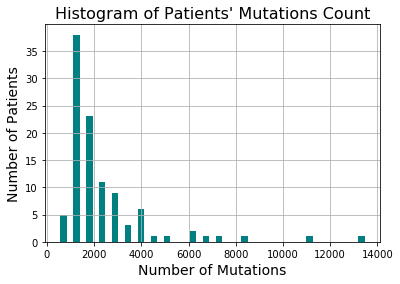

In [121]:
plt.xlabel("Number of Mutations", size=14)
plt.ylabel('Number of Patients', size=14)
plt.title("Histogram of Patients' Mutations Count", size=16)
#plt.ylim(0,2000)
#plt.xlim(0,400)

degrees = [item[1] for item in list(pi_degree.items())]

plt.hist(degrees, bins='auto', color='teal', rwidth=0.5)
plt.grid(True)
plt.savefig('pi_degree.png')

In [159]:
#patients and the drugs they take graph
E = nx.Graph()             

E.add_nodes_from(drug_mutation1['icgc_donor_id'], node_type = 'P')

E.add_nodes_from(drug_mutation1['Drug_list'], node_type = 'D')

E.add_edges_from([(row['icgc_donor_id'], row['Drug_list']) for idx, row in drug_mutation1.iterrows()], edge_type = 'pi_drug')

nx.info(E)

'Name: \nType: Graph\nNumber of nodes: 126\nNumber of edges: 193\nAverage degree:   3.0635'

In [289]:
len(C.neighbors('DO217786'))       #disease progression

1761

In [290]:
len(C.neighbors('DO218168'))         #stable disease

2416

In [150]:
drug_list = pd.read_csv("sorted_druglist1.csv")

In [293]:
#stable diesease response of Anastrozole patient
stable_res = drug_list[drug_list['second_therapy_response'] == 'stable disease']

In [294]:
#disease progression response of Anastrozole patient
prog_res = drug_list[drug_list['second_therapy_response'] == 'disease progression']

In [239]:
G_anas.neighbors("DO218168")

['ESR1']

In [240]:
G_anastrozole.neighbors("DO218168")

['ESR1']

In [245]:
#node attribute for mutation of complete response patient
anas_mu_stable = pd.DataFrame()
for genes in ['Gene name']:
    anas_mu_g[genes] = pd.Series('anas_comp')

anas_mu_g =anas_mu_g.T

anas_mu_g.to_csv("anas_comp.noa", sep='\t')

In [302]:
#comparing 3 patients who took Anastrozole for their second therapy and the responses. 

prog_anas = drug_list[drug_list['Drug_list'] == 'Anastrozole']
anas_res = prog_anas.loc[prog_anas['second_therapy_response'].isin(['stable disease','disease progression'])]

anas_mu_res = anas_res.merge(drug_mutation1, how="left")

In [42]:
anastrozole = target_paths2('Anastrozole')
Anas_g = nx.from_dict_of_lists(anastrozole,create_using=None)
nx.info(Anas_g)

'Name: \nType: Graph\nNumber of nodes: 345\nNumber of edges: 1001\nAverage degree:   5.8029'

In [45]:
#Graph of 3 patients who had known response taking Anastrozole

# add edges between drug and drug target 
Anas_g.add_edges_from([("Anastrozole", x) for x in B.neighbors("Anastrozole")], edge_type = 'drug_targ')

# mutated genes in the subnetwork
common_genes_anas = set(Anas_g.nodes()).intersection(pi_anas_mutated["Gene name"])
common_pi_anas_mu1 = pi_anas_mutated[pi_anas_mutated["Gene name"].isin(common_genes_anas)]

# add edges between patients and mutated genes 
mu_pi1 = common_pi_anas_mu1["icgc_donor_id"].tolist()
mutated_g1 = common_pi_anas_mu1["Gene name"].tolist()
Anas_g.add_edges_from(zip(mu_pi1, mutated_g1), edge_type = 'anas_mu')


nx.write_graphml(Anas_g, 'Anas_pi_mu3.graphml')

nx.info(Anas_g)

'Name: \nType: Graph\nNumber of nodes: 360\nNumber of edges: 1302\nAverage degree:   7.2333'

In [97]:
Anas_g.neighbors('DO217786')               #stable

['PLA2G6',
 'RORA',
 'NCOR2',
 'PIK3CA',
 'LHCGR',
 'IDO2',
 'DSCAM',
 'NRIP1',
 'GATA6',
 'SRD5A1',
 'GRB2',
 'RARB',
 'UXS1',
 'LRAT',
 'NCOA7',
 'HNF4G',
 'STRN',
 'NCOA2',
 'CYP2E1',
 'ESRRG',
 'CYP3A4',
 'PLA2G4A',
 'CYP2B6',
 'FSHR']

In [98]:
Anas_g.neighbors('DO218168')            #progression

['MAOA',
 'GRIP1',
 'ESR2',
 'CCNT1',
 'PISD',
 'IGF1',
 'GNA14',
 'MTA3',
 'CYP7B1',
 'UGDH',
 'ABCA3',
 'CYP11A1',
 'SAFB',
 'PPARA',
 'STK11',
 'ESR1',
 'AP1B1',
 'PGR',
 'GNAL',
 'HNF4G',
 'ESRRG',
 'MAOB',
 'NRIP1',
 'EGFR',
 'SGK3',
 'GNAQ',
 'CYP2C19']

In [100]:
Anas_g.neighbors('DO224996')                 #progression

['SP3',
 'CD82',
 'PIK3CA',
 'MTA3',
 'MAOA',
 'NR1I3',
 'GRB2',
 'SMARCD3',
 'HNF4G',
 'PPARA',
 'ATF2',
 'RARB',
 'ADH5',
 'CYP7B1',
 'UBC']

In [114]:
B.neighbors("CYP19A1")

['Nicotine',
 'Aminoglutethimide',
 'Testolactone',
 'Exemestane',
 'Letrozole',
 'Ketoconazole',
 'Anastrozole',
 '2-Methoxyestradiol',
 'atamestane-plus-toremifene',
 'MPI-674']